# OG-Learn Tutorial

**Overfit-to-Generalization Framework for Equitable Spatiotemporal Modeling**

This notebook demonstrates how to use `og-learn` to address local overfitting in spatiotemporal models.




## Contents

0. **Data Preparation** - Load data, calculate density, split train/test
1. **Quick Start** - Preset OG with default parameters
2. **Custom OG** - Use your own HV/LV models
3. **Model Comparison** - Compare OG vs standard models
4. **Understanding OG** - How it works

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sys
from pathlib import Path
%load_ext autoreload
%autoreload 2

# Add og_learn to path (for development)
OG_LEARN_ROOT = Path("..").resolve()
if str(OG_LEARN_ROOT) not in sys.path:
    sys.path.insert(0, str(OG_LEARN_ROOT))
    
from og_learn import (
    OGModel, compare_models, 
    calculate_density, split_test_train, simple_feature_engineering,
    load_data, sanity_check, save_split_indices
)

print("og-learn imported successfully!")


og-learn imported successfully!


## 0. Data Preparation

Load real spatiotemporal data, calculate density, and split into train/test sets.



### Configuration
| Variable | Description |
|----------|-------------|
| `DATA_PATH` | Path to your pickle file |
| `TARGET_COL` | Column name for target values |
| `FEATURE_COLS` | List of feature column names |


In [2]:
# ============================================================
# CONFIGURATION - Modify for your dataset
# ============================================================
DATA_PATH = 'data/df_example.pkl'  # Replace with your data
SAVE_DIR = 'diagnostics'           # Directory to save indices and diagnostics
SAMPLE = 100000                      # Sample size (None for full dataset)

TARGET_COL = 'Ozone'  # Target column

FEATURE_COLS = [
    'TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m', 'sp', 'WS10',
    'population', 'no2', 'DSR', 'strd', 'r_1000', 'lai_hv', 'pev',
    'ssro', 't_975', 't_925', 'tp', 'tsn', 'stl1', 'time', 'longitude', 'latitude'
]

# ============================================================
# Load Data (using utility function)
# ============================================================
df, FEATURE_COLS = load_data(DATA_PATH, FEATURE_COLS, TARGET_COL)

# Sanity check
sanity_check(df, FEATURE_COLS, TARGET_COL)


✓ Loaded 3,520,452 samples from 1,302 locations
  Time range: 2019-06-01 00:00:00 to 2019-09-29 23:00:00
  Target: Ozone
  Features: 23 columns
✓ Sanity check passed

Feature engineering options:
  ✓ Temporal harmonics available (time column found)
  ✓ Spatial harmonics available (longitude/latitude found)


True

### Split Data and Calculate Density 

(Density can be customized by your own function)

In [3]:
# ============================================================
# Split Data (Site-wise)
# ============================================================
# Site-wise split ensures no spatial leakage between train/test
_, _, train_idx, test_idx, df = split_test_train(
    df, sample=SAMPLE, split=0.2, flag='Site', seed=42, verbose=1
)

# Save split indices to diagnostics folder
save_split_indices(train_idx, test_idx, save_dir=SAVE_DIR)

# ============================================================
# Calculate Density using TRAIN stations only
# ============================================================
# This ensures test density is calculated based on train network
# (simulates real-world scenario where test locations are "new")
df = calculate_density(df, radius=500, reference_idx=train_idx)

print(f"\n✓ Density calculated (based on train stations)")
print(f"  Train density: {df.loc[train_idx, 'density'].min():.2e} - {df.loc[train_idx, 'density'].max():.2e}")
print(f"  Test density:  {df.loc[test_idx, 'density'].min():.2e} - {df.loc[test_idx, 'density'].max():.2e}")


Processing sample size: 100000
Using flag: Site
Selected Site Count: 260, (19.97%)
Selected DataRow Count: 19765, (19.77%)
Training Site Count: 1042, (80.03%)
Training DataRow Count: 80235, (80.23%)
✓ Split indices saved to diagnostics/
  - split_train_idx.npy (80,235 samples)
  - split_test_idx.npy (19,765 samples)


Calculating density (r=500km):   0%|          | 0/1302 [00:00<?, ?it/s]


✓ Density calculated (based on train stations)
  Train density: 1.81e-06 - 1.71e-04
  Test density:  2.76e-06 - 1.70e-04


### Feature Engineering

In [4]:
# ============================================================
# Feature Engineering
# ============================================================
# Temporal (add_temporal_harmonics=True):
#   - Extracts: time_month, time_day_of_month, time_hour
#   - Computes: T1, T2, T3 (temporal harmonics)
#   - Drops: 'time' column
# Spatial (add_spatial_harmonics=True):
#   - Computes: S1, S2, S3 (using original lon/lat)
#   - Drops: 'longitude', 'latitude'

X, y, FINAL_FEATURES = simple_feature_engineering(
    df,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL,
    add_spatial_harmonics=True,   # S1, S2, S3
    add_temporal_harmonics=True,  # T1, T2, T3, time_month, time_day_of_month, time_hour
    standardize=True
)

# Split into train/test
X_train = X.loc[train_idx].values
X_test = X.loc[test_idx].values
y_train = y.loc[train_idx].values
y_test = y.loc[test_idx].values

# Density for OG training (training samples only)
density_train = df.loc[train_idx, 'density'].values

print(f"\n✓ Features prepared: {X_train.shape}")
print(f"✓ Final features: {FINAL_FEATURES[:5]}... ({len(FINAL_FEATURES)} total)")


Feature Engineering Pipeline: fill NA → temporal harmonics → spatial harmonics → standardize
  ✓ Added temporal features: time_month, time_day_of_month, time_hour, T1, T2, T3
  ✓ Standardized all features
  ✓ Added spatial harmonics: S1, S2, S3 (replaced lon/lat)

Final features (29): ['TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m']...

✓ Features prepared: (80235, 29)
✓ Final features: ['TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m']... (29 total)


## 1. Quick Start - Preset OG

Now that data is prepared, use OG with preset models.

### Available Presets (from `get_model_configs`)

**HV Models (High-Variance for pseudo-label generation):**
| Name | Description |
|------|-------------|
| `lightgbm` | Standard LightGBM (100 trees, 300 leaves) |
| `biglightgbm` | Large LightGBM (1200 leaves) |
| `xgboost` | Standard XGBoost (100 trees) |
| `bigxgboost` | Large XGBoost (1200 trees) |
| `catboost` | Standard CatBoost (300 iters, depth 8) |
| `bigcatboost` | Large CatBoost (1000 iters, depth 7) |
| `random_forest` | RandomForest (5 trees, depth 20) |
| `decision_tree` | DecisionTree (depth 25) |

**LV Models (Low-Variance for generalization):**
| Name | Description |
|------|-------------|
| `mlp` | Standard MLP [512, 256, 128] |
| `bigmlp` | Large MLP [1024, 512×6, 256×5, 128, 64] |
| `resnet` | ResNet (6 blocks, 512 hidden) |
| `transformer` | FT-Transformer (depth 6, dim 32) |
| `gtransformer` | Global FT-Transformer |


In [5]:
# ============================================================
# View all available presets
# ============================================================
from og_learn import list_presets
list_presets()


HV Models (High-Variance for pseudo-label generation):
------------------------------------------------------------
  - lightgbm
  - biglightgbm
  - xgboost
  - bigxgboost
  - catboost
  - bigcatboost
  - random_forest
  - decision_tree
  - linear_regression

LV Models (Low-Variance for generalization):
------------------------------------------------------------
  - mlp
    Also: mlp_early (with early stopping)
  - bigmlp
    Also: bigmlp_early (with early stopping)
  - resnet
    Also: resnet_early (with early stopping)
  - transformer
    Also: transformer_early (with early stopping)


In [6]:
# # ============================================================
# # Preset OG: LightGBM (HV) + MLP (LV)
# # ============================================================
# og = OGModel(
#     hv='biglightgbm',       # High-variance: LightGBM for overfitting
#     lv='bigmlp',            # Low-variance: MLP for generalization
#     oscillation=0.05,
#     sampling_alpha=0.1,
#     epochs=300,
#     early_stopping=False, # Enable early stopping
#     # patience=5,          # Stop after 5 epochs without improvement
#     eval_every_epochs=10  # Evaluate every 5 epochs
# )

# # Fit with density and validation data
# og.fit(
#     X_train, y_train, 
#     density=density_train,
#     X_valid=X_test,      # Use test as validation for early stopping
#     y_valid=y_test
# )

# # Predict and evaluate
# y_pred = og.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# print(f"\n✓ OG Model Test R²: {r2:.4f}")


## 2. Custom OG - Your Own Models 


Use any model with `fit(X, y)` and `predict(X)` interface.


In [7]:
# # ============================================================
# # Custom HV Model
# # ============================================================
# from lightgbm import LGBMRegressor

# # Custom LightGBM with specific parameters
# custom_lgb = LGBMRegressor(
#     n_estimators=500,
#     num_leaves=500,
#     max_depth=25,
#     learning_rate=0.1,
#     min_child_samples=10,
#     verbose=-1
# )

# # Use custom HV with preset LV
# og_custom_hv = OGModel(
#     hv=custom_lgb,  # Your custom model
#     lv='mlp',
#     oscillation=0.03  # Less noise
# )

# og_custom_hv.fit(X_train, y_train, density=density_train)
# print(f"Custom HV Test R²: {og_custom_hv.score(X_test, y_test):.4f}")


In [8]:
# # ============================================================
# # Custom LV Model (Simple MLP example)
# # ============================================================
# from sklearn.neural_network import MLPRegressor as SklearnMLP

# # Custom sklearn MLP
# custom_mlp = SklearnMLP(
#     hidden_layer_sizes=(256, 128, 64),
#     activation='relu',
#     max_iter=200,
#     early_stopping=True,
#     validation_fraction=0.1,
#     random_state=42
# )

# # Use preset HV with custom LV
# og_custom_lv = OGModel(
#     hv='lightgbm',
#     lv=custom_mlp,  # Your custom model
#     oscillation=0.05
# )

# og_custom_lv.fit(X_train, y_train, density=density_train)
# print(f"Custom LV Test R²: {og_custom_lv.score(X_test, y_test):.4f}")


## 3. Model Comparison

Compare OG models against standard baselines.


### 3.1 Standard ML models

 

View training curves in browser using TensorBoard. All models share the same dashboard.

**Usage:**
1. Run cell below to start training with TensorBoard logging
2. Open http://localhost:6006 in browser
3. View real-time training curves for all models


In [ ]:
# ============================================================
# TensorBoard: View training curves in browser
# ============================================================
import shutil
import os
from og_learn.framework import launch_tensorboard
from og_learn.presets import get_hv_model, get_lv_model
from sklearn.linear_model import Ridge

# Clear old logs for fresh start
TB_LOG_DIR = 'diagnostics/tensorboard'

# Launch TensorBoard (opens http://localhost:6006)
tb_process = launch_tensorboard(TB_LOG_DIR, open_browser=True)

# Run comparison with TensorBoard logging
# Training curves will be logged and viewable in real-time
EPOCHS = 200
EVAL_EVERY = 5  # Log to TensorBoard every 5 epochs

models_tb = {
    # === HV Models (all presets) ===
    'LightGBM': get_hv_model('lightgbm'),
    'BigLightGBM': get_hv_model('biglightgbm'),
    'XGBoost': get_hv_model('xgboost'),
    'BigXGBoost': get_hv_model('bigxgboost'),
    'CatBoost': get_hv_model('catboost'),
    'BigCatBoost': get_hv_model('bigcatboost'),
    'RandomForest': get_hv_model('random_forest'),
    'DecisionTree': get_hv_model('decision_tree'),
    
    # === LV Models (with TensorBoard logging) ===
    'MLP': get_lv_model('mlp', num_features=X_train.shape[1], epochs=EPOCHS),
    'BigMLP': get_lv_model('bigmlp', num_features=X_train.shape[1], epochs=EPOCHS),
    'Transformer': get_lv_model('transformer', num_features=X_train.shape[1], epochs=EPOCHS),
    'Resnet': get_lv_model('resnet', num_features=X_train.shape[1], epochs=EPOCHS),
        
    # === OG Models ===
    'OG_MLP': OGModel(hv='lightgbm', lv='mlp', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY), 
    'OG_BigMLP': OGModel(hv='biglightgbm', lv='bigmlp', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY),
    
    # === OG Models ===
    'CatBoost_MLP': OGModel(hv='CatBoost', lv='mlp', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY), 
    'CatBoost_BigMLP': OGModel(hv='CatBoost', lv='bigmlp', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY),

    # === OG Models ===
    'CatBoost_RESNET': OGModel(hv='CatBoost', lv='resnet', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY), 
    'BigCatBoost_RESNET': OGModel(hv='BigCatBoost', lv='resnet', epochs=EPOCHS, eval_every_epochs=EVAL_EVERY), 


    
}

results_tb = compare_models(
    X_train, y_train, X_test, y_test,
    models=models_tb,
    density=density_train,
    tensorboard_dir=TB_LOG_DIR,  # <-- Enable TensorBoard logging
    eval_every_epochs=EVAL_EVERY,  # Log every 5 epochs
    save_dir=TB_LOG_DIR  # Save/load models (same dir as tensorboard)
)

# When done, stop TensorBoard:
# tb_process.terminate()


📊 TensorBoard started at http://localhost:6006
   Log directory: diagnostics/tensorboard
Model Comparison
📊 TensorBoard: tensorboard --logdir=diagnostics/tensorboard
   Open http://localhost:6006 to view training curves

Loading: LightGBM (from diagnostics/tensorboard\LightGBM\model.pkl)
  → R²: 0.5653 (loaded)

Loading: BigLightGBM (from diagnostics/tensorboard\BigLightGBM\model.pkl)
  → R²: 0.5658 (loaded)

Loading: XGBoost (from diagnostics/tensorboard\XGBoost\model.pkl)
  → R²: 0.5663 (loaded)

Loading: BigXGBoost (from diagnostics/tensorboard\BigXGBoost\model.pkl)


c:\Users\isxzl\miniconda3\envs\ozone\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


  → R²: 0.5659 (loaded)

Loading: CatBoost (from diagnostics/tensorboard\CatBoost\model.pkl)
  → R²: 0.5826 (loaded)

Loading: BigCatBoost (from diagnostics/tensorboard\BigCatBoost\model.pkl)
  → R²: 0.5690 (loaded)

Loading: RandomForest (from diagnostics/tensorboard\RandomForest\model.pkl)
  → R²: 0.5228 (loaded)

Loading: DecisionTree (from diagnostics/tensorboard\DecisionTree\model.pkl)
  → R²: 0.1684 (loaded)

Loading: MLP (from diagnostics/tensorboard\MLP\model.pkl)
  → R²: 0.5541 (loaded)

Loading: BigMLP (from diagnostics/tensorboard\BigMLP\model.pkl)
  → R²: 0.4839 (loaded)

Loading: Transformer (from diagnostics/tensorboard\Transformer\model.pkl)
  → R²: 0.5189 (loaded)

Training: Resnet...
  📊 TensorBoard: Resnet


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]

  → R²: 0.4784
  💾 Saved to diagnostics/tensorboard\Resnet\model.pkl

Training: OG_MLP...
  📊 TensorBoard: OG_MLP (dir=diagnostics/tensorboard)
  📊 TensorBoard: OG_MLP


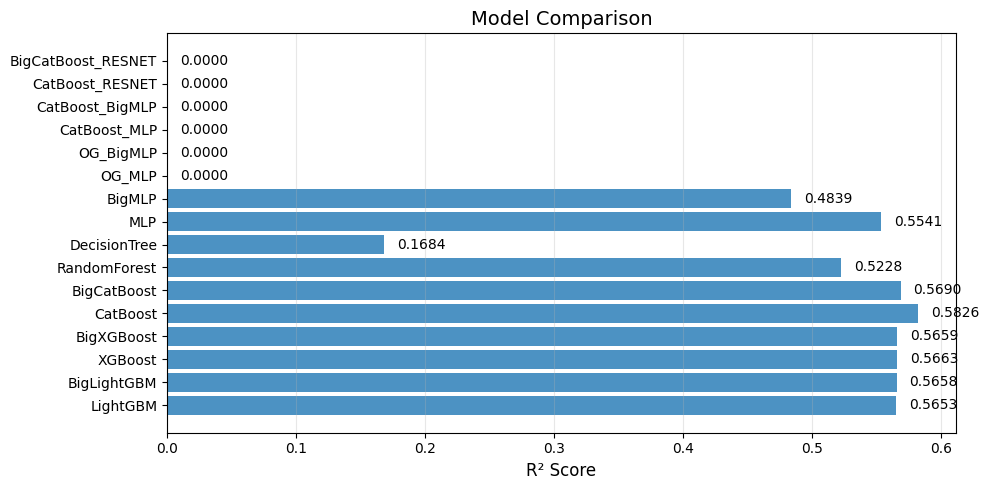

In [ ]:
# ============================================================
# Visualize comparison
# ============================================================
fig, ax = plt.subplots(figsize=(10, 5))

names = list(results_tb.keys())
scores = [results_tb[n] if results_tb[n] is not None else 0 for n in names]

# Color OG models differently
colors = ['#2ca02c' if 'OG' in n else '#1f77b4' for n in names]

bars = ax.barh(names, scores, color=colors, alpha=0.8)
ax.set_xlabel('R² Score', fontsize=12)
ax.set_title('Model Comparison', fontsize=14)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


## 4. Understanding OG

### The Problem: Local Overfitting

When data is non-uniformly distributed:
- **Dense areas**: Models overfit, achieving high accuracy
- **Sparse areas**: Models underperform, poor generalization

### The Solution: OG Framework

**Stage 1 (Overfit)**: High-variance model (e.g., LightGBM) deliberately overfits to capture local patterns.

**Stage 2 (Generalize)**: Low-variance model (e.g., MLP) learns from pseudo-labels with:
- **Density-aware sampling**: Prioritize sparse regions
- **Oscillation noise**: Regularization through noise injection

### Key Parameters

| Parameter | Description | Effect |
|-----------|-------------|--------|
| `oscillation` | Noise level (0.01-0.1) | Higher = more regularization |
| `sampling_alpha` | Density weight (0-1) | Higher = prioritize sparse areas |
| `epochs` | Training iterations | More = better fit, risk of overfit |

### Available Presets

| HV Models | LV Models |
|-----------|----------|
| `'lightgbm'` | `'mlp'` |
| `'xgboost'` | `'resnet'` |
| `'catboost'` | `'transformer'` |
